In [2]:
from espei.paramselect import _build_feature_matrix
from espei.paramselect import *

```json
{
    "components": ["MO"],
    "phases": ["BCC_A2"],
    "conditions": {"P": 101315, "T": 298.15},
    "excluded_model_contributions": ["idmix", "mag"],
    "output": "V0",
    "solver": {
        "mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [["MO"]], "sublattice_occupancies": [[1.0]]
    }, 
    "values": [[[9.250831259667694e-06]]],
    "reference": "VASP (LLNL)", "bibtex": "UNPUBLISHED", "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
    "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
}
```

```json
{"components": ["MO", "TI"], "phases": ["BCC_A2"], "conditions": {"P": 101315, "T": 298.15}, "excluded_model_contributions": ["idmix", "mag"], "output": "V0", "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["MO", "TI"]], [["MO", "TI"]], [["MO", "TI"]]], "sublattice_occupancies": [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]}, "values": [[[9.211708049305773e-06, 9.326822111574006e-06, 9.558979735164664e-06]]], "reference": "VASP (LLNL)", "bibtex": "UNPUBLISHED", "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING", "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]}```

In [3]:
from typing import List, Optional
from dataclasses import dataclass
import itertools
from numpy.typing import ArrayLike
import numpy as np
import symengine
from pycalphad import Model


class FittingStep():
    parameter_name: str
    data_types_read: List[str]
    features: List[symengine.Expr]
    supported_reference_states: List[str]

    @staticmethod
    def transform_data(d: ArrayLike, model: Optional[Model] = None) -> ArrayLike:  # data may be muddied with symbols from Model
        return d

    @staticmethod
    def transform_feature(f: symengine.Expr, model: Optional[Model] = None) -> symengine.Expr:
        return f

    @classmethod
    def get_feature_sets(cls):
        return make_successive(cls.features)


class ModelFittingDescription():
    def __init__(self, *fitting_steps) -> None:
        self.fitting_steps = fitting_steps


class StepV0(FittingStep):
    parameter_name = "V0"
    data_types_read = ["V0"]
    features = [symengine.S.One]
    supported_reference_states = [""]  # TODO: add mixing support

class StepLogVA(FittingStep):
    # V = V0*exp(VA), to linearize in terms of VA features, we want to fit
    # VA = ln(V/V0)
    parameter_name = "VA"
    data_types_read = ["V"]
    features = [v.T, v.T**2, v.T**3, v.T**(-1)]
    supported_reference_states = [""]  # TODO: add mixing support

    @staticmethod
    def transform_data(d: ArrayLike, model: Model) -> ArrayLike:
        # We are given samples of d = V.
        # ln(V/V0) = VA
        # cast to object_ because the real type may become a symengine.Expr
        d = np.asarray(d, dtype=np.object_)
        for i in range(d.shape[0]):
            d[i] = symengine.log(d[i] / model.V0)
        return d

    @classmethod
    def get_feature_sets(cls):
        # All combinations of features
        return list(itertools.chain(*(itertools.combinations(cls.features, n) for n in range(1, len(cls.features)+1))))

molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)

# Digitized data
v0 = 10.1092e-6
Texp = np.asarray([274.5886654478977, 317.001828153565, 376.9652650822671, 455.94149908592334, 531.9926873857406, 602.1937842778796, 691.4076782449727, 850.8226691042048, 945.8866544789764, 1081.9012797074956, 1232.5411334552105])
Vexp = np.asarray([0.0000102595070150209, 0.000010282702483979838, 0.000010316942197393508, 0.00001036333044520191, 0.000010413028200193464, 0.000010467137734726063, 0.00001052456686435235, 0.000010640519998161758, 0.000010715609696499606, 0.000010824930365395328, 0.000010955226490404716])

def fit_model_x(model_fitting_description: ModelFittingDescription):
    pass


In [4]:
# fake pycalphad "model" for testing
class DummyModel():
    V0 = symengine.Float(10.1092e-6)

sample_condition_dicts = [{v.T: x} for x in Texp.tolist()]
fitting_step = StepLogVA
from espei.parameter_selection.selection import fit_model, select_model

candidate_models = []
for features in fitting_step.get_feature_sets():
    feature_matrix = _build_feature_matrix(sample_condition_dicts, list(map(fitting_step.transform_feature, features)))
    data_quantities = fitting_step.transform_data(Vexp, DummyModel())
    candidate_model = (features, feature_matrix, data_quantities)
    print(candidate_model)
    candidate_models.append(candidate_model)
    # coeffs = fit_model(feature_matrix, data_quantities, 1e-100)
    print(features)
print('selection')
selected_features, selected_coeffs = select_model(candidate_models, 1e-100, 1.0)
print(selected_features, selected_coeffs)

((T,), array([[ 274.58866545],
       [ 317.00182815],
       [ 376.96526508],
       [ 455.94149909],
       [ 531.99268739],
       [ 602.19378428],
       [ 691.40767824],
       [ 850.8226691 ],
       [ 945.88665448],
       [1081.90127971],
       [1232.54113346]]), array([0.0147588890431954, 0.0170172126980282, 0.0203415171193124,
       0.0248277563882257, 0.0296118333891493, 0.0347947094090344,
       0.0402663253641889, 0.0512234544001933, 0.0582556281931518,
       0.0684059407831344, 0.0803707471216833], dtype=object))
(T,)
((T**2,), array([[  75398.93519246],
       [ 100490.1590527 ],
       [ 142102.81107854],
       [ 207882.65058872],
       [ 283016.2194319 ],
       [ 362637.35382291],
       [ 478044.5775361 ],
       [ 723899.2142616 ],
       [ 894701.56312143],
       [1170510.37903272],
       [1519157.64565905]]), array([0.0147588890431954, 0.0170172126980282, 0.0203415171193124,
       0.0248277563882257, 0.0296118333891493, 0.0347947094090344,
       0.040266

In [4]:
feature_matrix = np.asarray([Texp, Texp**2, Texp**3, Texp**(-1)]).T
data_quantities = np.log(Vexp / v0)

coeffs_4 = fit_model(feature_matrix, data_quantities, 1e-100)  # x
print(coeffs_4)

feature_matrix = np.asarray([Texp, Texp**2, Texp**(-1)]).T
data_quantities = np.log(Vexp / v0)
coeffs_3 = fit_model(feature_matrix, data_quantities, 1e-100)  # x
print(coeffs_3)

coeffs_p = np.asarray([4.87439e-5, 2.66296e-8/2, 0/3, -1*-0.076014])  # implicit deriv w.r.t. paper
print(coeffs_p)

[ 4.66279865e-05  1.78496695e-08 -2.35355512e-12  1.57461278e-01]
[4.89888044e-05 1.31616264e-08 4.19590479e-02]
[4.87439e-05 1.33148e-08 0.00000e+00 7.60140e-02]


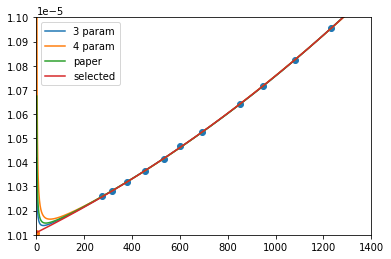

In [5]:
import matplotlib.pyplot as plt
tc = np.linspace(0, 1400, 1001)
vc_3 = v0 * np.exp(coeffs_3[0]*tc + coeffs_3[1]*tc**2 + coeffs_3[2]*tc**(-1))
vc_4 = v0 * np.exp(coeffs_4[0]*tc + coeffs_4[1]*tc**2 + coeffs_4[2]*tc**3 + coeffs_4[3]*tc**(-1))
vc_p = v0 * np.exp(coeffs_p[0]*tc + coeffs_p[1]*tc**2 + coeffs_p[2]*tc**3 + coeffs_p[3]*tc**(-1))
vc_sel = v0 * np.exp(selected_coeffs[0]*tc + selected_coeffs[1]*tc**2)  # hardcoded
plt.plot(tc, vc_3, label="3 param")
plt.plot(tc, vc_4, label="4 param")
plt.plot(tc, vc_p, label="paper")
plt.plot(tc, vc_sel, label="selected")
plt.scatter(Texp, Vexp)
plt.scatter(0, v0)
plt.xlim(0, 1400)
plt.ylim(10.1e-6,11.0e-6)
plt.legend()

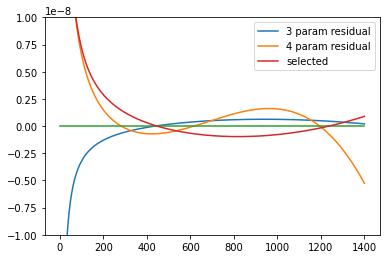

In [6]:
plt.plot(tc, vc_3-vc_p, label="3 param residual")
plt.plot(tc, vc_4-vc_p, label="4 param residual")
plt.plot(tc, vc_p-vc_p, label="")
plt.plot(tc, vc_p-vc_sel, label="selected")
plt.ylim(-1e-8, 1e-8)
plt.legend()

In [75]:
# def fit_redlich_kister_model(dbf, comps, phase_name, configuration, symmetry, datasets, aicc_phase_penalty=None, features=None):
#     # TODO: concept of a reference state needed
#     aicc_feature_factors = aicc_phase_penalty if aicc_phase_penalty is not None else {}
#     fitting_steps = ["V0"]
#     features = []

In [74]:
# from espei.parameter_selection.selection import fit_model
# # Solve Ax = b
# feature_matrix = np.asarray([[1], ])  # A
# data_quantities = np.asarray([9.250831259667694e-06])  # b
# model_coefficients = fit_model(feature_matrix, data_quantities, 1e-100)  # x
# print(model_coefficients)

# # L0 candidate model
# feature_matrix = np.asarray([
#     [0.1875, 0, 0], # 0.75,0.25
#     [0.25, 0, 0],  # 0.50,0.50
#     [0.1875, 0, 0],  # 0.25,0.75
#     ])  # A
# data_quantities = np.asarray([7500, 10000, 7500])  # b
# model_coefficients = fit_model(feature_matrix, data_quantities, 1e-100)  # x
# print(model_coefficients)

# # L0+L1 candidate model
# feature_matrix = np.asarray([
#     [0.75*0.25, 0.75*0.25*(0.75*0.25), 0], # 0.75,0.25
#     [0.5*0.5, 0.5*0.5*(0.5*0.5), 0],  # 0.50,0.50
#     [0.25*0.75, 0.25*0.75*(0.25*0.75), 0],  # 0.25,0.75
#     ])  # A
# data_quantities = np.asarray([7500, 10000, 7500])  # b
# model_coefficients = fit_model(feature_matrix, data_quantities, 1e-100)  # x
# print(model_coefficients)

# # L0+L1+L2 candidate model
# feature_matrix = np.asarray([
#     [0.75*0.25, 0.75*0.25*(0.75*0.25), 0.75*0.25*(0.75*0.25)**2], # 0.75,0.25
#     [0.5*0.5, 0.5*0.5*(0.5*0.5), 0.5*0.5*(0.5*0.5)**2],  # 0.50,0.50
#     [0.25*0.75, 0.25*0.75*(0.25*0.75), 0.25*0.75*(0.25*0.75)**2],  # 0.25,0.75
#     ])  # A
# data_quantities = np.asarray([7500, 10000, 7500])  # b
# model_coefficients = fit_model(feature_matrix, data_quantities, 1e-100)  # x
# print(model_coefficients)


In [73]:
# # work in progress: building feature sets for multiple non-interaction features (e.g. T _and_ P)
# # small refactor of build_feature_sets to allow for multiple non-interaction feature lists that are made successive and we take the product of the successive lists

# class X:
#     def __init__(self, s) -> None:
#         self.s = s
#     def __mul__(self, other):
#         return X(self.s + "*" + other.s)
#     def __str__(self) -> str:
#         return self.s
#     def __repr__(self) -> str:
#         return self.s

# import itertools
# from functools import reduce
# from operator import mul
# def distributive_multiply(*lists):
#     return list(map(lambda x: reduce(mul, x), itertools.product(*lists)))

# @cacheit  # This can be expensive if run from an inner loop, so it is cached
# def build_feature_sets(interaction_features, *noninteraction_feature_sets):
#     """
#     Return a list of broadcasted features

#     Parameters
#     ----------
#     temperature_features : list
#         List of temperature features that will become a successive_list, such as [TlogT, T-1, T2]
#     interaction_features : list
#         List of interaction features that will become a successive_list, such as [YS, YS*Z, YS*Z**2]

#     Returns
#     -------
#     list

#     Notes
#     -----
#     This allows two sets of features, e.g. [TlogT, T-1, T2] and [YS, YS*Z, YS*Z**2]
#     and generates a list of feature sets where the temperatures and interactions
#     are broadcasted successively.

#     Generates candidate feature sets like:
#     L0: A + BT,  L1: A
#     L0: A     ,  L1: A + BT

#     but **not** lists that are not successive:
#     L0: A + BT,  L1: Nothing, L2: A
#     L0: Nothing, L1: A + BT

#     There's still some debate whether it makes sense from an information theory
#     perspective to add a L1 B term without an L0 B term. However this might be
#     more representative of how people usually model thermodynamics.

#     Does not distribute multiplication/sums or make assumptions about the elements
#     of the feature lists. They can be strings, ints, objects, tuples, etc..

#     The number of features (related to the complexity) is a geometric series.
#     For :math:`N` temperature features and :math:`M` interaction features, the total
#     number of feature sets should be :math:`N(1-N^M)/(1-N)`. If :math:`N=1`, then there
#     are :math:`M` total feature sets.

#     """
#     successive_noninteraction_feature_sets = []
#     for feature_set in noninteraction_feature_sets:
#         # [[A], [A, B], [A, B, C], ...]
#         successive_noninteraction_feature_sets.append(make_successive(feature_set))
#     # Get the Cartesian product of all non-interaction feature sets
#     # Features from different sets are multiplied together
#     # print(list(itertools.product(*successive_noninteraction_feature_sets)))
#     # print('dm', list(map(lambda x: distributive_multiply(*x), successive_noninteraction_feature_sets)))
#     noninteraction_features = list(itertools.chain(map(lambda x: distributive_multiply(*x), successive_noninteraction_feature_sets)))
#     print(noninteraction_features)
#     # [ [noninteraction_features for L0], [noninteraction_features for L1], [noninteraction_features for L2], ...]
#     feats = [list(itertools.product(noninteraction_features, [inter])) for inter in interaction_features]
#     # [ [noninteraction_features for L0], [noninteraction_features for L0 and L1], [noninteraction_features for L0, L1 and L2], ...
#     model_sets = make_successive(feats)
#     # models that are not distributed or summed
#     candidate_feature_sets = list(itertools.chain(*[list(itertools.product(*model_set)) for model_set in model_sets]))
#     candidate_models = []
#     for feat_set in candidate_feature_sets:
#         # multiply the interactions through and flatten the feature list
#         candidate_models.append(list(itertools.chain(*[[param_order[1]*temp_feat for temp_feat in param_order[0]] for param_order in feat_set])))
#     return candidate_models

# cms = build_feature_sets([X("L0"), X("L1"), X("L2")], [X("1"), X("T"), X("T**2")], [X("1"), X("P"), X("P**2")])
# print(len(cms))
# cms